In [2]:
import json
from shapely.geometry import shape, Point
from shapely.ops import nearest_points
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib.request
import simplejson
from cluster_model import ClusterModel
from datetime import timedelta
import pickle
import seaborn as sns
import networkx as nx
from state_optimization import StateOptimization
import integer_programming as ip

# Boroughs

In [3]:
# use correct path to the geojson file
with open("/Users/andrewyoo/PycharmProjects/CSUREMM/new-york-city-boroughs.geojson") as f:
    boroughs_geojson = json.load(f)

# def classify_borough(lat, lon, boroughs_geojson):
#     point = Point(lon, lat)
#     for feature in boroughs_geojson['features']:
#         polygon = shape(feature['geometry'])
#         if polygon.contains(point):
#             return feature['properties']['name']  # or appropriate property name
#     return 'Unknown'

def classify_borough(lat, lon, boroughs_geojson):
    point = Point(lon, lat)
    min_distance = float('inf')
    nearest_borough = 'Unknown'
    
    for feature in boroughs_geojson['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']  # or appropriate property name
        # Calculate the distance to the nearest point on the polygon
        nearest_point = nearest_points(point, polygon)[1]
        distance = point.distance(nearest_point)
        if distance < min_distance:
            min_distance = distance
            nearest_borough = feature['properties']['name']
    
    return nearest_borough

In [4]:
# this may take a minute...
with open('/Users/andrewyoo/PycharmProjects/CSUREMM/data.pickle', 'rb') as f:
    station_data = pickle.load(f)

cluster_model = ClusterModel(station_data=station_data, in_transit=[], tph=4)
horizontal_squares, vertical_squares, clusters = cluster_model.cluster_stations(0.006)
cluster_model.init_clusters()
# cluster_model.init_state(path='/Users/Timothy/Documents/CSUREMM-main/data/station_data/status_at_time/2024_6_20_2:19.csv',
#                          time=timedelta(hours=2))

boro_dict = {}
for cluster in cluster_model.cluster_dict.values():
    boro_dict[cluster.name] = classify_borough(cluster.lat, cluster.lon, boroughs_geojson)

30 horizontal squares and 43 vertical squares. Total squares: 1290


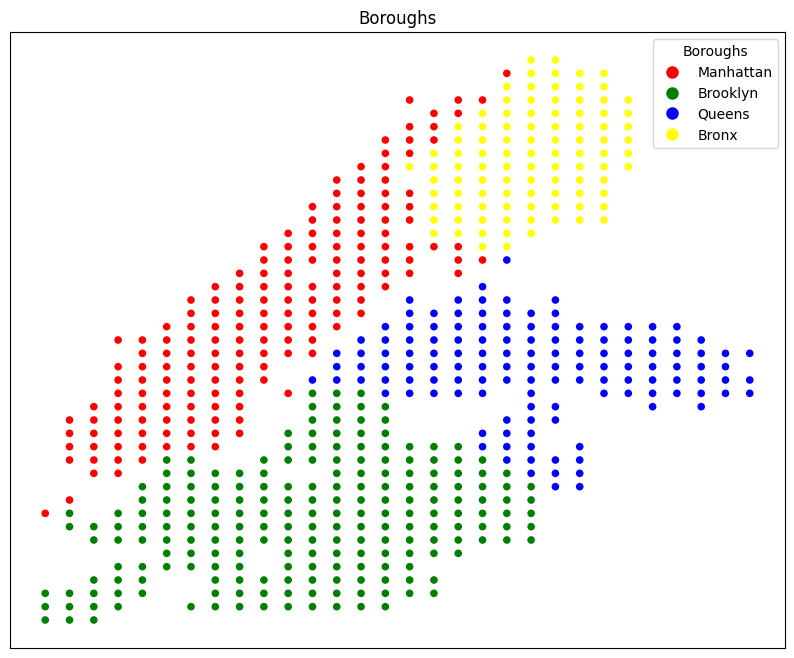

In [5]:
color_map = {'Manhattan': 'red', 'Brooklyn': 'green', 'Queens': 'blue', 'Bronx': 'yellow'}

G = nx.DiGraph()

positions = {}
node_colors = []

for cluster in cluster_model.cluster_dict.values():
    positions[cluster] = (cluster.lon, cluster.lat)
    G.add_node(cluster)
    borough = boro_dict.get(cluster.name, 'Unknown')
    node_colors.append(color_map.get(borough, 'lightgray'))  # Default to 'lightgray' if borough not found

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, positions, node_size=20, node_color=node_colors)
legend_elements = [Line2D([0], [0], marker='o', color='w', label=borough, markersize=10, markerfacecolor=color) 
                   for borough, color in color_map.items()]
plt.legend(handles=legend_elements, title="Boroughs")
plt.title("Boroughs")
plt.show()

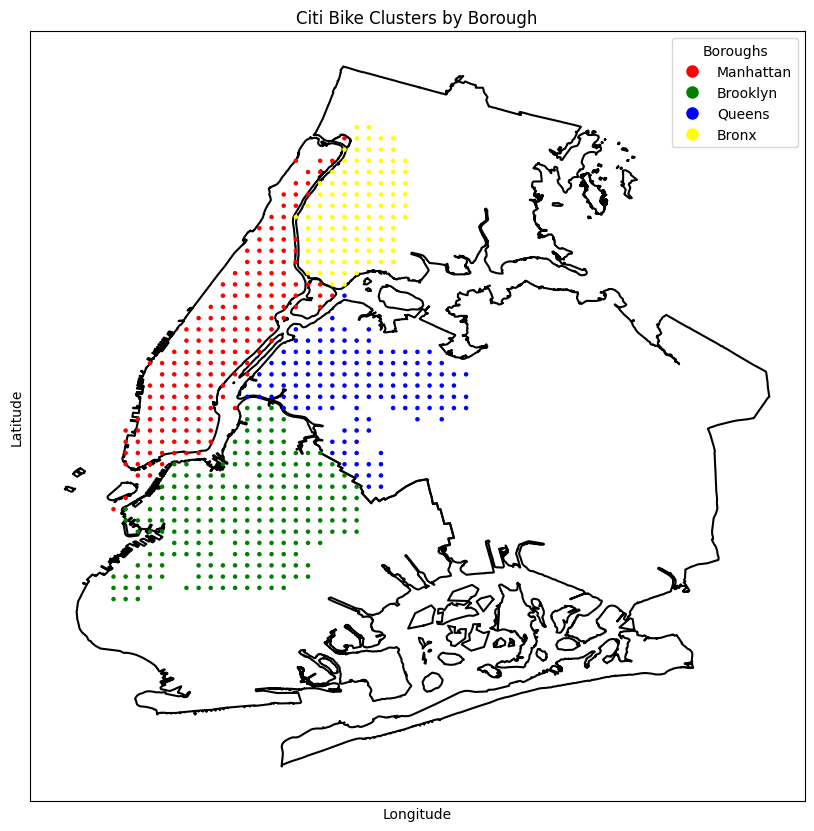

In [6]:
import json
from shapely.geometry import shape, Polygon, MultiPolygon
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D
from geojson import load

# Load the GeoJSON file for borough boundaries
with open('/Users/andrewyoo/PycharmProjects/CSUREMM/new-york-city-boroughs.geojson') as f:
    geojson_data = load(f)

# Extract the geometries and borough names
geometries = []
borough_names = []

for feature in geojson_data['features']:
    geom = shape(feature['geometry'])
    borough_name = feature['properties']['name']
    
    if borough_name in color_map:  # Only add boroughs that have nodes
        geometries.append(geom)
        borough_names.append(borough_name)

# Plot the borough boundaries
fig, ax = plt.subplots(figsize=(10, 10))

for geom, borough_name in zip(geometries, borough_names):
    if isinstance(geom, Polygon):
        x, y = geom.exterior.xy
        ax.plot(x, y, 'k')
    elif isinstance(geom, MultiPolygon):
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            ax.plot(x, y, 'k')

# For the nodes
color_map = {'Manhattan': 'red', 'Brooklyn': 'green', 'Queens': 'blue', 'Bronx': 'yellow'}

G = nx.DiGraph()

positions = {}
node_colors = []

# Assuming cluster_model and boro_dict are defined elsewhere
for cluster in cluster_model.cluster_dict.values():
    positions[cluster] = (cluster.lon, cluster.lat)
    G.add_node(cluster)
    borough = boro_dict.get(cluster.name, 'Unknown')
    if borough in color_map:  # Only add nodes for boroughs in color_map
        node_colors.append(color_map[borough])
    else:
        node_colors.append('lightgray')  # Default color for unknown boroughs

# Draw network nodes on the existing plot
nx.draw_networkx_nodes(G, positions, node_size=5, node_color=node_colors, ax=ax)

# Create legend for boroughs
legend_elements = [Line2D([0], [0], marker='o', color='w', label=borough, markersize=10, markerfacecolor=color) 
                   for borough, color in color_map.items()]
ax.legend(handles=legend_elements, title="Boroughs")

# Add plot titles and labels
plt.title('Citi Bike Clusters by Borough')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


# Neighborhoods

In [7]:
with open("/Users/andrewyoo/PycharmProjects/CSUREMM/nyc-neighborhoods.geo.json") as f:
    neighborhoods_geojson = json.load(f)

In [8]:
def classify_neighborhood(lat, lon, boroughs_geojson):
    point = Point(lon, lat)
    min_distance = float('inf')
    nearest_borough = 'Unknown'
    
    for feature in neighborhoods_geojson['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']  # or appropriate property name
        # Calculate the distance to the nearest point on the polygon
        nearest_point = nearest_points(point, polygon)[1]
        distance = point.distance(nearest_point)
        if distance < min_distance:
            min_distance = distance
            nearest_neighborhood = feature['properties']['name']
    
    return nearest_neighborhood

In [9]:
# this may take a minute...
with open('/Users/andrewyoo/PycharmProjects/CSUREMM/data.pickle', 'rb') as f:
    station_data = pickle.load(f)

cluster_model = ClusterModel(station_data=station_data, in_transit=[], tph=4)
horizontal_squares, vertical_squares, clusters = cluster_model.cluster_stations(0.006)
cluster_model.init_clusters()
# cluster_model.init_state(path='/Users/Timothy/Documents/CSUREMM-main/data/station_data/status_at_time/2024_6_20_2:19.csv',
#                          time=timedelta(hours=2))

neighborhood_dict = {}
for cluster in cluster_model.cluster_dict.values():
    neighborhood_dict[cluster.name] = classify_neighborhood(cluster.lat, cluster.lon, neighborhoods_geojson)

30 horizontal squares and 43 vertical squares. Total squares: 1290


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)


In [10]:
# List of neighborhoods that actually have stations in them
neighborhood_list = []
for neighborhood in neighborhood_dict.values():
    if neighborhood not in neighborhood_list:
        neighborhood_list.append(neighborhood)

# List of bad neighborhoods to highlight in our graph
bad_neighborhoods = ['Flatbush', 'East Flatbush-Farragut', 'Sunset Park East', 'Sunset Park West', 'Crown Heights South', 'Crown Heights North']

In [11]:
neighborhood_list

['Spuyten Duyvil-Kingsbridge',
 'Van Cortlandt Village',
 'Marble Hill-Inwood',
 'Bedford Park-Fordham North',
 'Washington Heights North',
 'Kingsbridge Heights',
 'Belmont',
 'University Heights-Morris Heights',
 'Fordham South',
 'Mount Hope',
 'East Tremont',
 'Washington Heights South',
 'Claremont-Bathgate',
 'Highbridge',
 'East Concourse-Concourse Village',
 'West Concourse',
 'Morrisania-Melrose',
 'Crotona Park East',
 'Hamilton Heights',
 'Central Harlem North-Polo Grounds',
 'Melrose South-Mott Haven North',
 'Longwood',
 'Hunts Point',
 'Soundview-Bruckner',
 'Manhattanville',
 'East Harlem North',
 'Morningside Heights',
 'Central Harlem South',
 'Mott Haven-Port Morris',
 'Upper West Side',
 'East Harlem South',
 'Steinway',
 'Upper East Side-Carnegie Hill',
 'Yorkville',
 'Lincoln Square',
 'Old Astoria',
 'Clinton',
 'Midtown-Midtown South',
 'Lenox Hill-Roosevelt Island',
 'Queensbridge-Ravenswood-Long Island City',
 'Astoria',
 'Woodside',
 'Jackson Heights',
 'East 

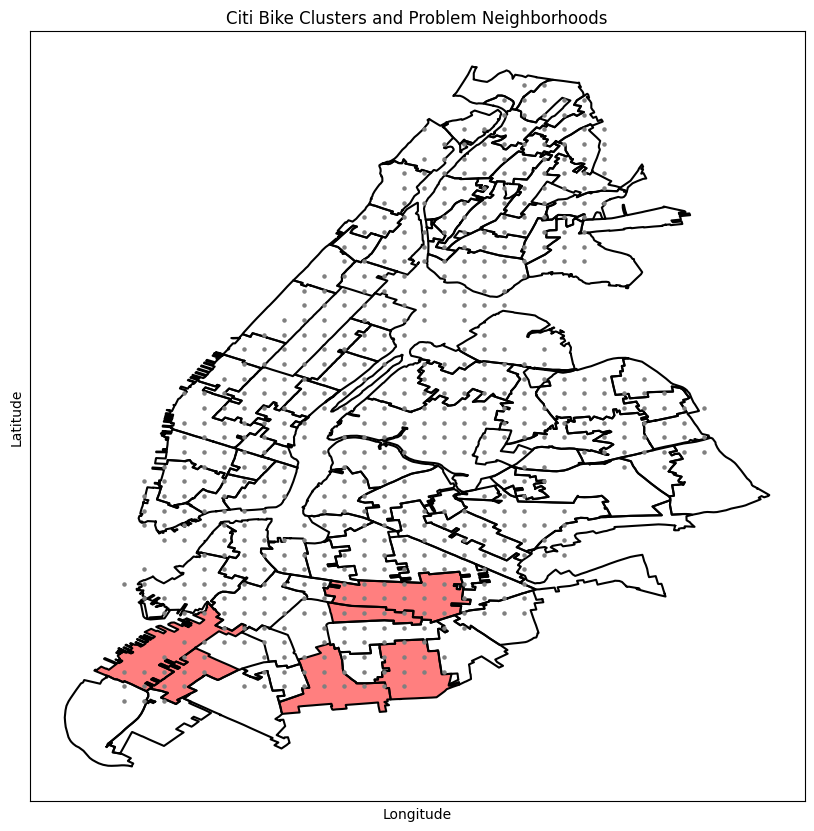

In [12]:
import json
from shapely.geometry import shape, Polygon, MultiPolygon
import matplotlib.pyplot as plt
import networkx as nx
from geojson import load

# Load the GeoJSON file for neighborhood boundaries
with open("/Users/andrewyoo/PycharmProjects/CSUREMM/nyc-neighborhoods.geo.json") as f:
    geojson_data = load(f)

# Extract the geometries and properties (neighborhood names)
geometries = []
properties = []

for feature in geojson_data['features']:
    if feature['properties']['name'] in neighborhood_list:
        geometry = shape(feature['geometry'])
        properties.append(feature['properties'])
        geometries.append(geometry)

# Plot the geometries
fig, ax = plt.subplots(figsize=(10, 10))

for geom, prop in zip(geometries, properties):
    neighborhood_name = prop['name']
    if isinstance(geom, Polygon):
        x, y = geom.exterior.xy
        if neighborhood_name in bad_neighborhoods:
            ax.fill(x, y, 'red', alpha=0.5)  # Fill in red with transparency
        ax.plot(x, y, 'k')
    elif isinstance(geom, MultiPolygon):
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            if neighborhood_name in bad_neighborhoods:
                ax.fill(x, y, 'red', alpha=0.5)  # Fill in red with transparency
            ax.plot(x, y, 'k')

# Assuming cluster_model and neighborhood_dict are defined elsewhere
G = nx.DiGraph()
positions = {}

for cluster in cluster_model.cluster_dict.values():
    positions[cluster] = (cluster.lon, cluster.lat)
    G.add_node(cluster)
    neighborhood = neighborhood_dict.get(cluster.name, 'Unknown')

# Draw network nodes on the existing plot
nx.draw_networkx_nodes(G, positions, node_size=5, node_color='gray', ax=ax)

# Add plot titles and labels
plt.title('Citi Bike Clusters and Problem Neighborhoods')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


### In case something goes wrong you can come back to this

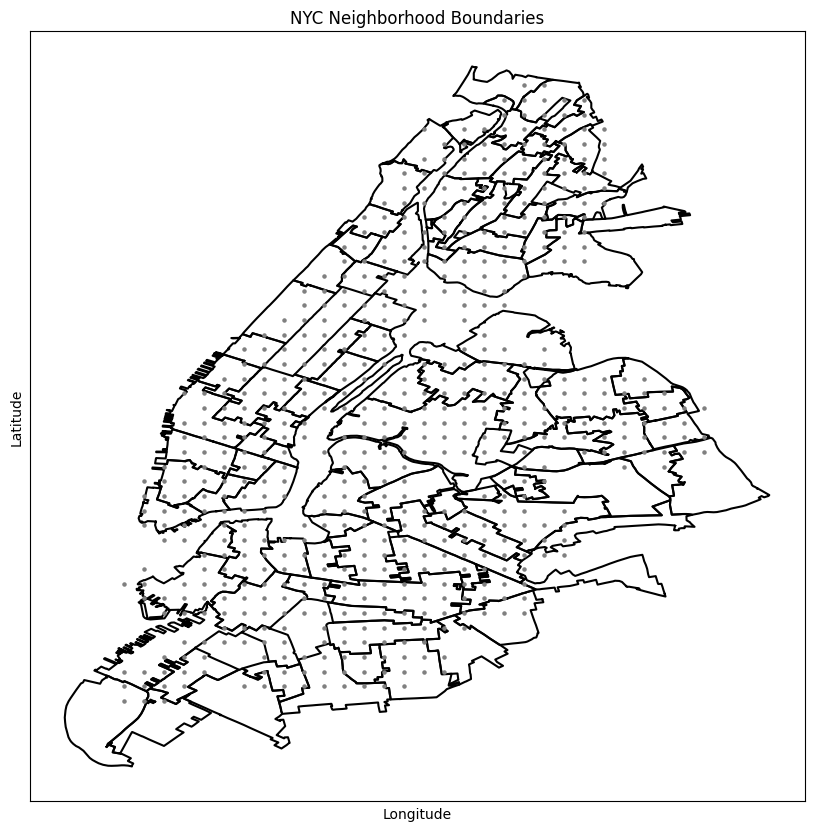

In [12]:
import json
from shapely.geometry import shape, Polygon, MultiPolygon
import matplotlib.pyplot as plt
from geojson import load

# Load the GeoJSON file
with open("/Users/andrewyoo/PycharmProjects/CSUREMM/nyc-neighborhoods.geo.json") as f:
    geojson_data = load(f)

# Extract the geometries
geometries = [shape(feature['geometry']) for feature in geojson_data['features'] 
              if feature['properties']['name'] in neighborhood_list]

# Plot the geometries
fig, ax = plt.subplots(figsize=(10, 10))

for geom in geometries:
    if isinstance(geom, Polygon):
        x, y = geom.exterior.xy
        ax.plot(x, y, 'k')
    elif isinstance(geom, MultiPolygon):
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            ax.plot(x, y, 'k')

G = nx.DiGraph()

positions = {}
node_colors = []

# Assuming cluster_model and neighborhood_dict are defined elsewhere
for cluster in cluster_model.cluster_dict.values():
    positions[cluster] = (cluster.lon, cluster.lat)
    G.add_node(cluster)
    neighborhood = neighborhood_dict.get(cluster.name, 'Unknown')

# Draw network nodes on the existing plot
nx.draw_networkx_nodes(G, positions, node_size=5, node_color='gray', ax=ax)

# Add plot titles and labels
plt.title('NYC Neighborhood Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

# IP w/ neighborhoods

Initialize the model and create borough and neighborhood dictionaries (actually they were already created earlier):

In [13]:
with open('/Users/andrewyoo/PycharmProjects/CSUREMM/data.pickle', 'rb') as f:
    station_data = pickle.load(f)

cluster_model = ClusterModel(station_data=station_data, in_transit=[], tph=4)
horizontal_squares, vertical_squares, clusters = cluster_model.cluster_stations(0.006)
cluster_model.init_clusters()
cluster_model.init_state(path='/Users/andrewyoo/PycharmProjects/CSUREMM/status_at_time/2024_6_20_2:19.csv' , time=timedelta(hours=23))

30 horizontal squares and 43 vertical squares. Total squares: 1290


Let's just focus on the neighborhoods in Brooklyn. There are some really low performing neighborhoods but also some that are pretty good. So, hopefully we can find truck routes within Brooklyn that work.

In [14]:
# List of neighborhoods that actually have stations in them
neighborhood_list, cluster_list = [], [] # cluster list is of objects, not names
for cluster in neighborhood_dict.keys():
    if boro_dict[cluster] == "Brooklyn":
        cluster_list.append(cluster_model.cluster_dict[cluster])
        if neighborhood_dict[cluster] not in neighborhood_list:
            neighborhood_list.append(neighborhood_dict[cluster])

Now, we want to set up what we need for integer programming

In [38]:
clusters = [cluster.name for cluster in cluster_list]
start_levels = {cluster.name: cluster.curr_bikes for cluster in cluster_model.cluster_dict.values() if cluster.name in clusters}
positions = {cluster.name: (cluster.lon, cluster.lat) for cluster in cluster_model.cluster_dict.values() if cluster.name in clusters}
adjacency = cluster_model.get_adjacent_clusters()
neighbors = adjacency.copy()
for cluster in adjacency.keys():
    if cluster not in clusters:
        del neighbors[cluster]

In [16]:
with open('/Users/andrewyoo/PycharmProjects/CSUREMM/data.pickle', 'rb') as f:
    station_data = pickle.load(f)

cluster_model_1 = ClusterModel(station_data=station_data, in_transit=[], tph=4)
horizontal_squares, vertical_squares, clusters_1 = cluster_model_1.cluster_stations(0.006)
cluster_model_1.init_clusters()
# change to 6 AM start
cluster_model_1.init_state(path='/Users/andrewyoo/PycharmProjects/CSUREMM/status_at_time/2024_6_20_2:19.csv' , time=timedelta(hours=6)) 

state_optimization = StateOptimization(cluster_model_1)
opt_state = state_optimization.optimize(length=timedelta(hours=4), steps=8)
optimal_levels = opt_state.copy()
for cluster in opt_state.keys():
    if cluster not in clusters:
        del optimal_levels[cluster]

30 horizontal squares and 43 vertical squares. Total squares: 1290
Step 1 of 8 completed 423 failures
Step 2 of 8 completed 161 failures
Step 3 of 8 completed 227 failures
Step 4 of 8 completed 92 failures
Step 5 of 8 completed 96 failures
Step 6 of 8 completed 158 failures
Step 7 of 8 completed 69 failures
Step 8 of 8 completed 96 failures


In [20]:
for neighbor_list in neighbors.values():
    for cluster in neighbor_list:
        if cluster not in clusters or cluster == 731: # WHYYYYYYYY
            neighbor_list.remove(cluster)

In [21]:
T = 60
K = 2
L = 10

## Normal Objective Function

In [22]:
ip_model, x1, y, b = ip.create_model(T=T, K=K, L=L,  #changed to x1 for graphing part
                stations=clusters,
                start_levels=start_levels, 
                optimal_levels=optimal_levels, 
                positions=positions,  
                neighbors=neighbors)

# truck_paths = ip.graph_model(x, b, K, T, clusters, positions)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 91763 rows, 50489 columns and 400764 nonzeros
Model fingerprint: 0x4d339d45
Variable types: 0 continuous, 50489 integer (25080 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 14559 rows and 11738 columns
Presolve time: 0.32s
Presolved: 77204 rows, 38751 columns, 342308 nonzeros
Variable types: 0 continuous, 38751 integer (25134 binary)
Found heuristic solution: objective 73.0000000

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 77204 rows, 38751 columns, 342308 nonzeros

Concurrent spin time: 0.05s

Solved with dual simplex

Root relaxation: objective 3.300

Graph it: we're not using the function bc we wanna graph neighborhood boundaries on top of this

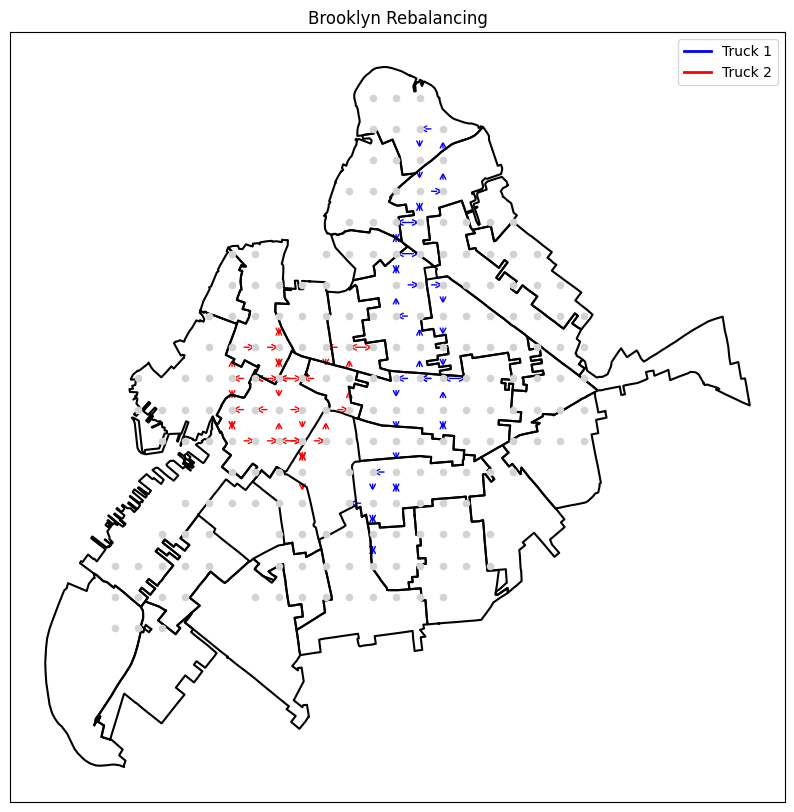

In [23]:
stations = clusters
node_size = 20
title = "Brooklyn Rebalancing"


# Load the GeoJSON file for neighborhood boundaries
with open("/Users/andrewyoo/PycharmProjects/CSUREMM/nyc-neighborhoods.geo.json") as f:
    geojson_data = load(f)

# Extract the geometries and properties (neighborhood names)
geometries = []
properties = []

for feature in geojson_data['features']:
    if feature['properties']['name'] in neighborhood_list:
        geometry = shape(feature['geometry'])
        properties.append(feature['properties'])
        geometries.append(geometry)

# Plot the geometries
fig, ax = plt.subplots(figsize=(10, 10))

for geom, prop in zip(geometries, properties):
    neighborhood_name = prop['name']
    if isinstance(geom, Polygon):
        x, y = geom.exterior.xy
        # if neighborhood_name in bad_neighborhoods:
        #     ax.fill(x, y, 'red', alpha=0.5)  # Fill in red with transparency
        ax.plot(x, y, 'k')
    elif isinstance(geom, MultiPolygon):
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            # if neighborhood_name in bad_neighborhoods:
            #     ax.fill(x, y, 'red', alpha=0.5)  # Fill in red with transparency
            ax.plot(x, y, 'k')






truck_paths = {}
    
# if model.status == GRB.OPTIMAL:
if True:
    for k in range(1, K+1):
        path = []
        for t in range(1, T+1):
            for s in stations:
                if x1[s, t, k].x > 0.5:  # If the truck k is at station s at time t
                    path.append((t, s, '{} bikes'.format(int(b[t,k].x))))
                    break
        truck_paths[k] = path
        # print(f"Truck {k} path: {path}")
else:
    print("No optimal solution found.")

G = nx.DiGraph()

# Add nodes
for station in stations:
    G.add_node(station)

# Add edges with arrows for each truck path
for k, path in truck_paths.items():
    for i in range(len(path) - 1):
        t1, s1 = path[i][:2]
        t2, s2 = path[i + 1][:2]
        G.add_edge(s1, s2, truck=k, time_step=t1)

edge_colors = ['blue', 'red', 'green', 'purple']  # Different colors for different trucks

# plt.figure(figsize=(10, 8))
for k, path in truck_paths.items():
    # edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1)]
    # The above includes time steps where the trucks don't move. Below I have removed such trips
    edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1) if path[i][1] != path[i + 1][1]]
    nx.draw_networkx_edges(G, positions, edgelist=edges, arrowstyle='->', arrowsize=10, 
                           edge_color=edge_colors[k - 1], style='dashed', label=f'Truck {k}')

nx.draw_networkx_nodes(G, positions, node_size= node_size, node_color='lightgray')
# If we want to add labels we can
# nx.draw_networkx_labels(G, positions, font_size=10)

from matplotlib.lines import Line2D
legend_handles = [Line2D([0], [0], color=edge_colors[k - 1], lw=2, label=f'Truck {k}') for k in range(1, K+1)]
plt.legend(handles=legend_handles)

plt.title(title)
plt.show()

## Altered Objective Function

First, lets just visualize the bad stations in Brooklyn:

In [24]:
# List of neighborhoods that actually have stations in them
neighborhood_list, cluster_list = [], [] # cluster list is of objects, not names
for cluster in neighborhood_dict.keys():
    if boro_dict[cluster] == "Brooklyn":
        cluster_list.append(cluster_model.cluster_dict[cluster])
        if neighborhood_dict[cluster] not in neighborhood_list:
            neighborhood_list.append(neighborhood_dict[cluster])

# List of bad neighborhoods to highlight in our graph
bad_neighborhoods = ['Flatbush', 'East Flatbush-Farragut', 'Sunset Park East', 
                     'Sunset Park West', 'Crown Heights South', 'Crown Heights North']

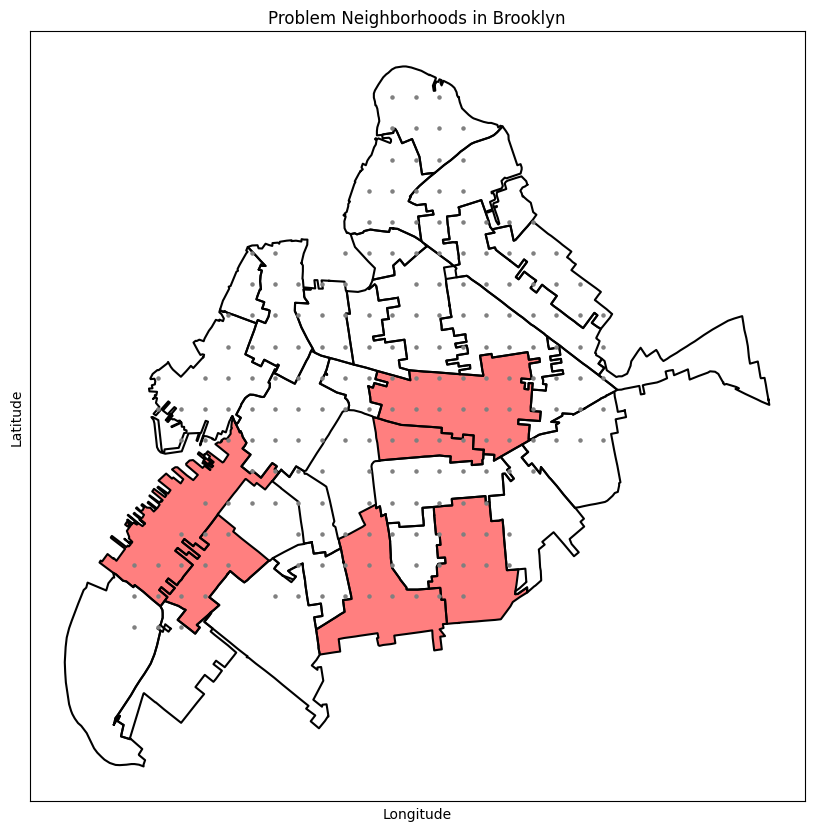

In [25]:
import json
from shapely.geometry import shape, Polygon, MultiPolygon
import matplotlib.pyplot as plt
import networkx as nx
from geojson import load

# Load the GeoJSON file for neighborhood boundaries
with open("/Users/andrewyoo/PycharmProjects/CSUREMM/nyc-neighborhoods.geo.json") as f:
    geojson_data = load(f)

# Extract the geometries and properties (neighborhood names)
geometries = []
properties = []

for feature in geojson_data['features']:
    if feature['properties']['name'] in neighborhood_list:
        geometry = shape(feature['geometry'])
        properties.append(feature['properties'])
        geometries.append(geometry)

# Plot the geometries
fig, ax = plt.subplots(figsize=(10, 10))

for geom, prop in zip(geometries, properties):
    neighborhood_name = prop['name']
    if isinstance(geom, Polygon):
        x, y = geom.exterior.xy
        if neighborhood_name in bad_neighborhoods:
            ax.fill(x, y, 'red', alpha=0.5)  # Fill in red with transparency
        ax.plot(x, y, 'k')
    elif isinstance(geom, MultiPolygon):
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            if neighborhood_name in bad_neighborhoods:
                ax.fill(x, y, 'red', alpha=0.5)  # Fill in red with transparency
            ax.plot(x, y, 'k')

# Assuming cluster_model and neighborhood_dict are defined elsewhere
G = nx.DiGraph()
node_positions = {}

# for cluster in cluster_model.cluster_dict.values():
# This was modified bc we just wanted Brooklyn!
for cluster in cluster_list:
    node_positions[cluster] = (cluster.lon, cluster.lat)
    G.add_node(cluster)
    neighborhood = neighborhood_dict.get(cluster.name, 'Unknown')

# Draw network nodes on the existing plot
nx.draw_networkx_nodes(G, node_positions, node_size=5, node_color='gray', ax=ax)

# Add plot titles and labels
plt.title('Problem Neighborhoods in Brooklyn')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

Now, we can run integer programming but change the objective function so that bad neighborhoods are given special preference, again we will put the ugly manual code in here so that we can change the objective function

In [26]:
stations=clusters
start_levels=start_levels
optimal_levels=optimal_levels
positions=positions
neighbors=neighbors

In [27]:
bad_clusters = [cluster for cluster in clusters if neighborhood_dict[cluster] in bad_neighborhoods]

In [28]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

over_stations, under_stations, balanced_stations = [], [], []
# Fill over and under stations
for station in stations:
    if start_levels[station] > optimal_levels[station]:
        over_stations.append(station)
    elif start_levels[station] < optimal_levels[station]:
        under_stations.append(station)
    else:
        balanced_stations.append(station)

model = gp.Model("bike_rebalancing")

# Decision variables
x, y, b = {}, {}, {}
for t in range(1, T+1):
    for k in range(1, K+1):
        for s in stations:
            x[s, t, k] = model.addVar(name="x_%s,%s,%s" % (s, t, k), vtype=GRB.BINARY)
            y[s, t, k] = model.addVar(name="y_%s,%s,%s" % (s, t, k), vtype=GRB.INTEGER)
        b[t, k] = model.addVar(name="b_%s,%s" % (t, k), vtype=GRB.INTEGER)

# Auxiliary variables for absolute deviation
deviation = {}
for s in stations:
    deviation[s] = model.addVar(name="deviation_%s" % s, vtype=GRB.INTEGER)

model.update()

# Objective function: minimize total absolute deviation from optimal levels
objective = gp.quicksum(deviation[s] for s in stations) + gp.quicksum(deviation[s] for s in bad_clusters)

model.setObjective(objective, sense=GRB.MINIMIZE)

# Constraints:

# Constraint 1: can only move to an adjacent station
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(x[s,t,k] <= x[s,t-1,k] + gp.quicksum(x[s1,t-1,k] for s1 in neighbors[s]))


# Constraint 2: each truck must be at exactly 1 station always
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(x[s, t, k] for s in stations) == 1)

# Constraint 3: initialize bike levels at time 1
for s in stations:
    model.addConstr(sum(y[s, 1, k] for k in range(1, K+1)) == start_levels[s])

# Constraint 4 & 5: rebalancing can only bring a station closer to optimal level
for t in range(1, T+1):
    for s in over_stations:
        # model.addConstr(optimal_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= start_levels[s])
    for s in under_stations:
        # model.addConstr(start_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= optimal_levels[s])
    for s in balanced_stations:
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) == start_levels[s])

# Constraint 6: total number of bikes is constant
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(y[s, t, k] for s in stations) + b[t, k] == sum(y[s, 1, k] for s in stations) + b[1, k])

# Constraint 7: can move only when truck is at station; number of bikes moved is bounded
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(y[s, t, k] - y[s, t-1, k] <= L * x[s, t, k])
            model.addConstr(y[s, t-1, k] - y[s, t, k] <= L * x[s, t, k])

# Constraint 8: can either travel or load/unload, not both
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in over_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L + (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L - (y[s,t,k] - y[s,t-1,k]))
        for s in under_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L - (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L + (y[s,t,k] - y[s,t-1,k]))

# TEST: each truck can only house L bikes
for k in range(1, K+1):
    for t in range(1,T+1):
        model.addConstr(b[t,k] <= L)

# Absolute deviation constraints
for s in stations:
    model.addConstr(deviation[s] >= optimal_levels[s] - sum(y[s, T, k] for k in range(1, K+1)))
    model.addConstr(deviation[s] >= sum(y[s, T, k] for k in range(1, K+1)) - optimal_levels[s])

# At beginning and end, there must be no bikes in trucks
model.addConstr(gp.quicksum(b[T, k] for k in range(1, K+1)) == 0)
model.addConstr(gp.quicksum(b[1, k] for k in range(1, K+1)) == 0)

model.optimize()
model.update()

ip_model = model
x1 = x

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 91763 rows, 50489 columns and 400764 nonzeros
Model fingerprint: 0xea896b96
Variable types: 0 continuous, 50489 integer (25080 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 14559 rows and 11738 columns
Presolve time: 0.31s
Presolved: 77204 rows, 38751 columns, 342308 nonzeros
Variable types: 0 continuous, 38751 integer (25134 binary)
Found heuristic solution: objective 81.0000000

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 77204 rows, 38751 columns, 342308 nonzeros

Concurrent spin time: 0.05s

Solved with dual simplex

Root relaxation: objective 3.300

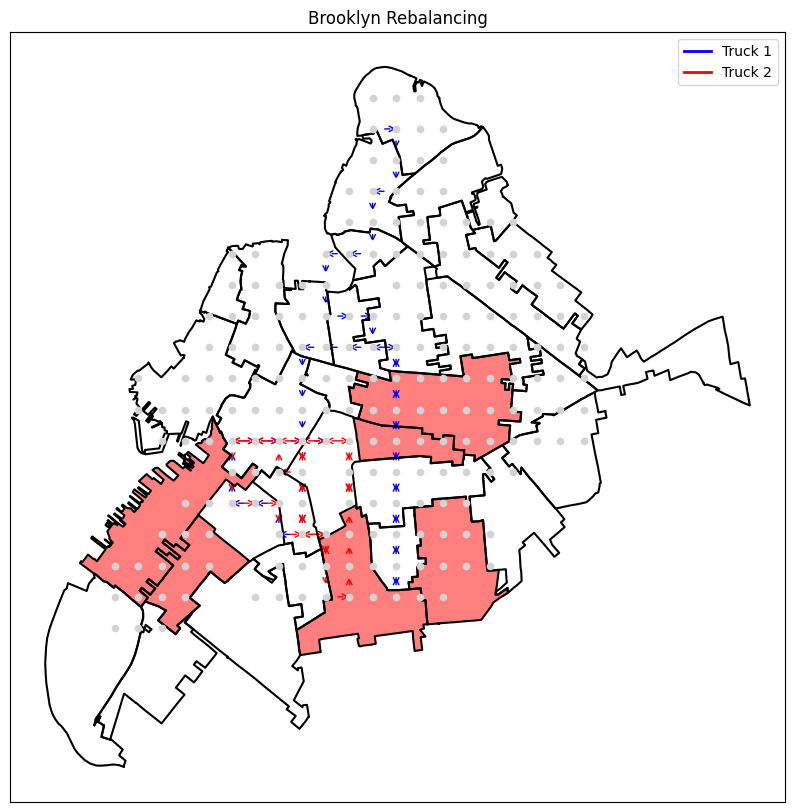

In [41]:
stations = clusters
node_size = 20
title = "Brooklyn Rebalancing"


# Load the GeoJSON file for neighborhood boundaries
with open("/Users/andrewyoo/PycharmProjects/CSUREMM/nyc-neighborhoods.geo.json") as f:
    geojson_data = load(f)

# Extract the geometries and properties (neighborhood names)
geometries = []
properties = []

for feature in geojson_data['features']:
    if feature['properties']['name'] in neighborhood_list:
        geometry = shape(feature['geometry'])
        properties.append(feature['properties'])
        geometries.append(geometry)

# Plot the geometries
fig, ax = plt.subplots(figsize=(10, 10))

for geom, prop in zip(geometries, properties):
    neighborhood_name = prop['name']
    if isinstance(geom, Polygon):
        x, y = geom.exterior.xy
        if neighborhood_name in bad_neighborhoods:
            ax.fill(x, y, 'red', alpha=0.5)  # Fill in red with transparency
        ax.plot(x, y, 'k')
    elif isinstance(geom, MultiPolygon):
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            if neighborhood_name in bad_neighborhoods:
                ax.fill(x, y, 'red', alpha=0.5)  # Fill in red with transparency
            ax.plot(x, y, 'k')






truck_paths = {}
    
# if model.status == GRB.OPTIMAL:
if True:
    for k in range(1, K+1):
        path = []
        for t in range(1, T+1):
            for s in stations:
                if x1[s, t, k].x > 0.5:  # If the truck k is at station s at time t
                    path.append((t, s, '{} bikes'.format(int(b[t,k].x))))
                    break
        truck_paths[k] = path
        # print(f"Truck {k} path: {path}")
else:
    print("No optimal solution found.")

G = nx.DiGraph()

# Add nodes
for station in stations:
    G.add_node(station)

# Add edges with arrows for each truck path
for k, path in truck_paths.items():
    for i in range(len(path) - 1):
        t1, s1 = path[i][:2]
        t2, s2 = path[i + 1][:2]
        G.add_edge(s1, s2, truck=k, time_step=t1)

edge_colors = ['blue', 'red', 'green', 'purple']  # Different colors for different trucks

# plt.figure(figsize=(10, 8))
for k, path in truck_paths.items():
    # edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1)]
    # The above includes time steps where the trucks don't move. Below I have removed such trips
    edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1) if path[i][1] != path[i + 1][1]]
    nx.draw_networkx_edges(G, positions, edgelist=edges, arrowstyle='->', arrowsize=10, 
                           edge_color=edge_colors[k - 1], style='dashed', label=f'Truck {k}')

nx.draw_networkx_nodes(G, positions, node_size= node_size, node_color='lightgray')
# If we want to add labels we can
# nx.draw_networkx_labels(G, positions, font_size=10)

from matplotlib.lines import Line2D
legend_handles = [Line2D([0], [0], color=edge_colors[k - 1], lw=2, label=f'Truck {k}') for k in range(1, K+1)]
plt.legend(handles=legend_handles)

plt.title(title)
plt.show()